In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from data_utils import put_in_PI, find_angle_id, find_next_frame, generate_sample
import json
from tqdm import tqdm

In [2]:
DATA_ROOT_DIR = "../training_data/"

df = pd.read_csv(DATA_ROOT_DIR + 'interpolated.csv')

In [3]:
# extract image from center camera
center_cam_idx = df['frame_id'] == 'center_camera'
center_cam_df = df[center_cam_idx]

# Convert steering angle to [-pi, pi] and clamp too large angle
center_cam_df['angle'] = center_cam_df['angle'].apply(put_in_PI)

/home/mquan/.venv/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
max_angle = max(center_cam_df['angle'])
min_angle = min(center_cam_df['angle'])
print("max_angle = ", max_angle, "\tmin_angle = ", min_angle)

max_angle =  1.903261912290081 	min_angle =  -2.0507619380950928


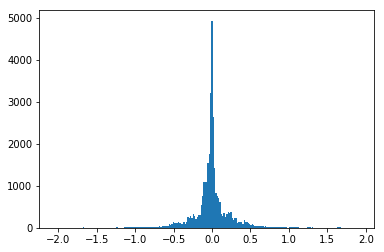

In [5]:
bin_width = 1. * np.pi / 180
num_bins = math.ceil((max_angle - min_angle) / bin_width) + 1
bins = [min_angle + i * bin_width for i in range(int(num_bins))]

bins_cnt, bins_edge, _ = plt.hist(center_cam_df['angle'], bins=bins)

In [6]:
len(bins_edge)

228

Text(0, 0.5, 'percentage')

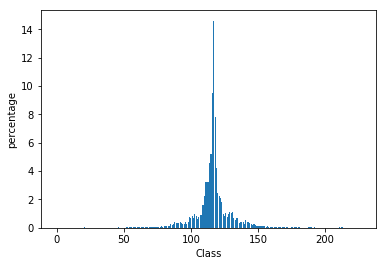

In [6]:
class_portion = bins_cnt*100. / np.sum(bins_cnt)
plt.bar(np.arange(len(bins_cnt)).astype(int), class_portion)
plt.xlabel("Class")
plt.ylabel("percentage")


In [7]:
max_idx = np.argmax(bins_cnt)
print("Most frequence interval: [%.3f, %.3f]" % (bins_edge[max_idx], bins_edge[max_idx + 1]))

Most frequence interval: [-0.009, 0.009]


# Calculate weight of each class of angle 
* Find median of the whole dataset
* Calculate weights for each class
The weight is calculated according to `median frequency balancing`

$w(c) = \frac{\text{meadian freq of whole dataset}}{\text{freq of class c}}$

*Ref: https://stats.stackexchange.com/questions/284265/understanding-median-frequency-balancing*

In [8]:
classes_freq = bins_cnt / len(center_cam_df)
# find median of the whole dataset
median_freq = np.median(classes_freq)
# claculate weight of each class
classes_weights = {}
for i, freq in enumerate(classes_freq):
    if freq < 1e-7:
        classes_weights[i] = 0
    else:
        classes_weights[i] =  median_freq / freq

In [9]:
# save classes_weights to file
with open('classes_weight.json', 'w') as outfile:
    json.dump(classes_weights, outfile)

Text(0.5, 0, 'Class ID')

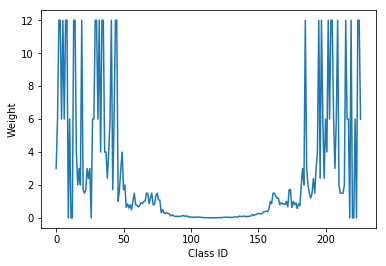

In [10]:
plt.plot([classes_weights[i] for i in range(len(classes_freq))])
plt.ylabel('Weight')
plt.xlabel('Class ID')

# Data prepration
Generate a training sample as a `dict` with the following keys:

* frame_name: only 1 string - filename of the current frame
* inter_frame_dist: list of 4 floats
* angle_id: (just for last 4 frames)
* angle_val (just for last 4 frames)


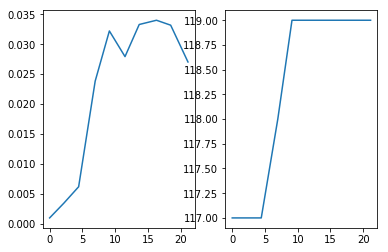

In [11]:
sample = generate_sample(0, center_cam_df, bins_edge, "", target_num_label_frame=10)

plt.subplot(121)
plt.plot(sample['travelled_dist'], sample['angle_val'])
plt.subplot(122)
plt.plot(sample['travelled_dist'], sample['angle_id'])

In [12]:
sample

{'frame_name': 'center/1479424215880976321.jpg',
 'travelled_dist': [0.0,
  2.1677148464764695,
  4.432220177530368,
  6.958004707503364,
  9.1257200668643,
  11.514011458981619,
  13.681727119609,
  16.32108661705235,
  18.488802618969366,
  21.12816274703459],
 'angle_id': [117, 117, 117, 118, 119, 119, 119, 119, 119, 119],
 'angle_val': [0.0010389390634089964,
  0.003490658476948738,
  0.006233516622372111,
  0.023837438906472504,
  0.03220005114149144,
  0.027925267815589905,
  0.033276625206141365,
  0.033986320752989164,
  0.03316125646233559,
  0.02703264515815083]}

## Create dataset

In [8]:
dataset = []  # list of dictionary
# now_idx_list = np.random.randint(0, high=len(center_cam_df)-1, size=int(0.7 * len(center_cam_df)))
now_idx_list = np.arange(2000)

for i in tqdm(now_idx_list):
    sample = generate_sample(i, center_cam_df, bins_edge, "", target_num_label_frame=10)
    # check if sample is valid
    if sample:
        dataset.append(sample)

100%|██████████| 2000/2000 [00:43<00:00, 46.19it/s]


In [9]:
dataset_df = pd.DataFrame(dataset)

In [10]:
dataset_df.to_csv("demo_dataset.csv")

In [15]:
def datasetSeparate(dataframe, training_portion):
    """
    Separate dataframe into training set (training_portion%) and validation set (1 - training_portion)
    
    :param dataframe:
    
    :return:
        training_df, validation_df
    """
    # shuffle dataframe
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    # separate
    training_end = int(training_portion * len(dataframe))
    training_df = dataframe.iloc[: training_end, :]
    validation_df = dataframe.iloc[training_end: , :]
    
    return training_df, validation_df

In [16]:
training_df, validation_df = datasetSeparate(dataset_df, 0.9)
training_df.to_csv("CH2_training.csv")
validation_df.to_csv("CH2_validation.csv")

In [18]:
np.save("bins_edge.npy", bins_edge)